In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}



Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [39]:
cd RNN

/content/drive/ee379kproject-master/RNN


In [17]:
import pandas as pd
import numpy
import sys
import nltk
nltk.download('punkt')
import re
import random
import matplotlib.pyplot as plt
from nltk import FreqDist
import math

from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Activation
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import load_model

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [40]:
raw_data = pd.read_csv("tweets_clustered_15_16_17_speeches.csv") #format: 0 = twitter, 1 = speech
raw_data.head()

,Unnamed: 0,synopsis,cluster,format_
0,"(11,)",Economists on the TAX CUTS and JOBS ACT:\n\n“T...,11,0
1,"(0,)",The media has been speculating that I fired Re...,0,0
2,"(5,)",RT @WhiteHouse: President Trump proclaims toda...,5,0
3,"(0,)",Republicans Senators are working hard to pass ...,0,0
4,"(0,)",The jury was not told the killer of Kate was a...,0,0


In [41]:
print raw_data.shape

(22752, 4)


## Visualize Length of Tweets

* We know Twitter used to have a 140 char limit, now it has been raised to 280
* When considering generating tweets, must generate a particular number of words and subsequent characters
* Rather than generating an arbitrary num of characters between [140,280] or even [0,280] (which would create far too many super short tweets), generate a length based on Trump's typical usage

In [42]:
raw_data['length'] = raw_data.apply(lambda x: len(x.synopsis), axis=1)
raw_data.head()

,Unnamed: 0,synopsis,cluster,format_,length
0,"(11,)",Economists on the TAX CUTS and JOBS ACT:\n\n“T...,11,0,231
1,"(0,)",The media has been speculating that I fired Re...,0,0,275
2,"(5,)",RT @WhiteHouse: President Trump proclaims toda...,5,0,113
3,"(0,)",Republicans Senators are working hard to pass ...,0,0,279
4,"(0,)",The jury was not told the killer of Kate was a...,0,0,173


In [43]:
raw_data.loc[raw_data['format_'] == 0]['length'].describe()

count    14173.000000
mean       116.417343
std         30.964453
min          2.000000
25%         98.000000
50%        129.000000
75%        139.000000
max        328.000000
Name: length, dtype: float64

The longest char tweet is likely due to a URL at the end of the tweet (which does not count towards character len).  Still think it's best to cap at 280 regardless of these exceptions

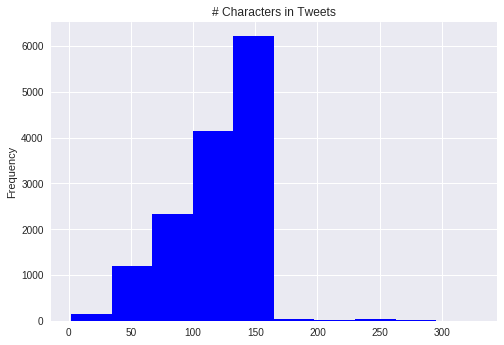

In [44]:
raw_data.loc[raw_data['format_'] == 0]['length'].plot.hist(title="# Characters in Tweets", color='b')
plt.show()

In [0]:
def get_tweet_length():
    tweet_len_dist = raw_data.loc[raw_data['format_'] == 0]['length'].value_counts()
    total_tweets = tweet_len_dist.sum()
    p = tweet_len_dist/total_tweets
    
    index = numpy.random.multinomial(1,p,1).argmax()
    return tweet_len_dist.index.values[index]

## Visualize number of words per tweet

* This might be insightful in tuning the seq_length parameter

In [47]:
raw_data['num_words'] = raw_data.apply(lambda x: len(x.synopsis.split()), axis=1)
raw_data.head()

,Unnamed: 0,synopsis,cluster,format_,length,num_words
0,"(11,)",Economists on the TAX CUTS and JOBS ACT:\n\n“T...,11,0,231,36
1,"(0,)",The media has been speculating that I fired Re...,0,0,275,46
2,"(5,)",RT @WhiteHouse: President Trump proclaims toda...,5,0,113,10
3,"(0,)",Republicans Senators are working hard to pass ...,0,0,279,51
4,"(0,)",The jury was not told the killer of Kate was a...,0,0,173,35


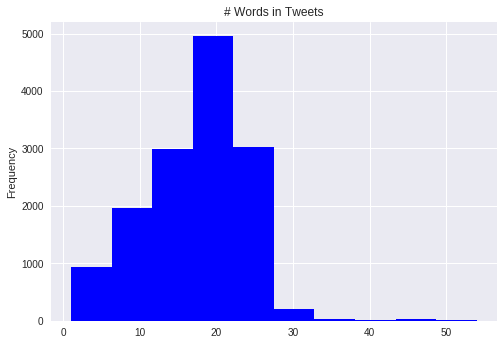

In [48]:
raw_data.loc[raw_data['format_'] == 0]['num_words'].plot.hist(title="# Words in Tweets", color='b')
plt.show()

In [49]:
raw_data.loc[raw_data['format_'] == 0]['num_words'].describe()

count    14173.000000
mean        17.308051
std          6.511801
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         54.000000
Name: num_words, dtype: float64

* On average, 17 words/tweet 
* interesting to see one tweet is only 1 word long - keep in mind that any tweets < seq_length set will not be trained on at all. This is probably ok if seq_length < 13. Any higher than 13 would cause loss of 25% of tweets (if using version 1 of building training set)

##  Grab Tweets related to a particular topic cluster 

Explore topics:
* Cluster 0 words: great country just hillary said want like looking clinton winning time 'm say big new years vote think bad trump president ll believe many american totally hillary ve got work interview making way enjoy did national things talking polls thank
* Cluster 1 words: making america america making making great great america https let making america safe together together together realdonaldtrump trump thank s let america great vote s safe america s let let let 's let 's big needed great trump //t.co/u25yi5t7e8 https
* Cluster 2 words: very right thank thank very very great good 's very very 's nice bad just very dishonest important very time said very sadness realdonaldtrump looking big think new very making https president watch years coming many tough very country very
* Cluster 3 words: day great great https big big realdonaldtrump just every today 's remember winning every 's thank trump tomorrow making people another happy elections amazing day like elections national love billion white american years memorial states many looking crowd white house
* Cluster 4 words: know n't n't know 's realdonaldtrump did said because does say said think people does did because did things like realdonaldtrump know want coming happens president ll trump know winning only does lot run just why mean right better mean
* Cluster 5 words: https thank rt join great trump today honor realdonaldtrump maga americafirst new draintheswamp realdonaldtrump imwithyou tomorrow maga video tickets polls clinton vote support living tickets watch makeamericagreatagain trump2016 americafirst ohio imwithyou votetrump draintheswamp welcome whitehouse crookedhillary american tonight president time
* Cluster 6 words: 's realdonaldtrump happens 's hillary time clinton country said let trump realdonaldtrump let clinton because like just 's america say good things right looking hillary america n't said think 's only great https 's why way bad 's hillary want
* Cluster 7 words: trump2016 https trump2016 makeamericagreatagain thank makeamericagreatagain makeamericagreatagain makeamericagreatagain trump2016 trump2016 new thank thank polls thank join thank votetrump supertuesday support indiana carolina great tomorrow thank realdonaldtrump thank america south south california thank soon america pennsylvania iowa thank new hampshire polls
* Cluster 8 words: people great great many american want american 's country many just coming n't say like because clinton love people hillary work realdonaldtrump vote said lot only https know crowd lot amazing trump new million looking got really people time ve
* Cluster 9 words: thank thank https true true http folks eric greta great love reminded beautiful ohio say thank thank service honor amazing everybody mississippi joe thank marks general increases care man erictrump sharing usa ve final ted iowa enemies jobs foxandfriends foxnews
* Cluster 10 words: realdonaldtrump trump run president needed thank love vote great trump2016 apprenticenbc please best run http watch celebapprentice celebrityapprentice realdonaldtrump man like country donald realdonaldtrump hopefully realdonaldtrump america 'm foxnews just true realdonaldtrump only foxandfriends time u makeamericagreatagain mr. winning agree
* Cluster 11 words: jobs great great bring bring country american created jobs good realdonaldtrump did new good 's trade just million thank lost tax manufacturing hillary https mexico many work people fantastic companies america clinton fantastic way business want deals today workers communities
* Cluster 12 words: states united united president president president united states america https country 's world great security national people deals trump realdonaldtrump run united states states border run mexico happens run making supreme supreme iran time court n't refugees trade citizens israel
* Cluster 13 words: trump http donald donald president https realdonaldtrump polls 's gop trump golf trump run donald trump thank newsmax_media great new think s breitbartnews lead winning presidential want donald makeamericagreatagain vote national asktrump donald say trump making only president love asktrump
* Cluster 14 words: n't ca ca does does did wo wo realdonaldtrump did n't n't want wait ca say think n't said why n't believe like trump winning n't because hillary n't just n't needed 's country let realdonaldtrump realdonaldtrump president used things

In [50]:
for c in range(0,15):
    cluster = raw_data.loc[raw_data['cluster'] == c]['synopsis']
    print 'Cluster ', c, ': ', cluster.shape, 'tweets'

Cluster  0 :  (9506,) tweets
Cluster  1 :  (529,) tweets
Cluster  2 :  (809,) tweets
Cluster  3 :  (349,) tweets
Cluster  4 :  (536,) tweets
Cluster  5 :  (1961,) tweets
Cluster  6 :  (1582,) tweets
Cluster  7 :  (449,) tweets
Cluster  8 :  (1141,) tweets
Cluster  9 :  (201,) tweets
Cluster  10 :  (2507,) tweets
Cluster  11 :  (722,) tweets
Cluster  12 :  (262,) tweets
Cluster  13 :  (996,) tweets
Cluster  14 :  (1202,) tweets


In [51]:
CLUSTER = 1 #Test with MAGA tweets 

clustered_data = raw_data.loc[raw_data['cluster'] == CLUSTER]['synopsis']
clustered_data.head()

11     Thank you @SenOrrinHatch. Let’s continue MAKIN...
63     Since the first day I took office, all you hea...
85                             MAKE AMERICA GREAT AGAIN!
86              @ThePlumLineGS MAKE AMERICA GREAT AGAIN!
145    One of the most accurate polls last time aroun...
Name: synopsis, dtype: object

## Do some data cleanup 

In [0]:
tweets = []
for i in clustered_data: 
    i = re.sub(r"http\S+", "", i) #remove all URLs
    i = re.sub(r"amp\S+", "", i) #remove all amps following &
    i = re.sub(r"“", '"', i) #standardize punctuation
    i = re.sub(r"”", '"', i)
    i = re.sub(r"’", "'", i)
    i = re.sub(r"‘", "'", i)
    i = re.sub(r"…", "...", i)
    tweets.append(i)

In [53]:
print 'Total number of tweets in CLUSTER ', CLUSTER, ":", len(tweets)
print '\nFirst 10 tweets: ', tweets[0:10]
numpy.savetxt('tweets.txt', tweets, fmt='%s')

Total number of tweets in CLUSTER  1 : 529

First 10 tweets:  ["Thank you @SenOrrinHatch. Let's continue MAKING AMERICA GREAT AGAIN!  ", 'Since the first day I took office, all you hear is the phony Democrat excuse for losing the election, Russia, Russia,Russia.  Despite this I have the economy booming and have possibly done more than any 10 month President. MAKE AMERICA GREAT AGAIN!', 'MAKE AMERICA GREAT AGAIN!', '@ThePlumLineGS MAKE AMERICA GREAT AGAIN!', "One of the most accurate polls last time around. But #FakeNews likes to say we're in the 30's. They are wrong. Some people think numbers could be in the 50's. Together, WE will MAKE AMERICA GREAT AGAIN! ", 'Happy birthday to the great @TheLeeGreenwood. You and your beautiful song have made such a difference. MAKE AMERICA GREAT AGAIN!', 'Happy birthday to the great @leegreenwood83. You and your beautiful song have made such a difference. MAKE AMERICA GREAT AGAIN!', 'Wacky & totally unhinged Tom Steyer, who has been fighting me and m

UnicodeDecodeError: ignored

## Tokenize words

In [54]:
# create mapping of unique chars to integers
all_text = ' '.join(tweets).decode('utf-8')

chars = sorted(list(set(all_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
print char_to_int
# for c in char_to_int:
#     print c
print len(all_text)

{u' ': 1, u'$': 5, u'(': 9, u',': 11, u'0': 15, u'4': 19, u'8': 23, u'@': 29, u'D': 33, u'H': 37, u'L': 41, u'P': 45, u'T': 49, u'd': 59, u'h': 63, u'l': 67, u'p': 71, u't': 75, u'x': 79, u'\u200b': 83, u'\u2013': 84, u'\xa0': 82, u'#': 4, u"'": 8, u'/': 14, u'3': 18, u'7': 22, u';': 26, u'?': 28, u'C': 32, u'G': 36, u'\U0001f44d': 87, u'K': 40, u'O': 44, u'S': 48, u'W': 52, u'_': 55, u'c': 58, u'g': 62, u'k': 66, u'o': 70, u's': 74, u'w': 78, u'\U0001f1fa': 86, u'\n': 0, u'"': 3, u'&': 7, u'.': 13, u'2': 17, u'6': 21, u':': 25, u'B': 31, u'F': 35, u'J': 39, u'N': 43, u'R': 47, u'V': 51, u'Z': 54, u'b': 57, u'f': 61, u'j': 65, u'n': 69, u'r': 73, u'v': 77, u'z': 81, u'!': 2, u'%': 6, u')': 10, u'-': 12, u'1': 16, u'5': 20, u'9': 24, u'=': 27, u'A': 30, u'E': 34, u'I': 38, u'M': 42, u'Q': 46, u'U': 50, u'Y': 53, u'a': 56, u'e': 60, u'i': 64, u'm': 68, u'q': 72, u'u': 76, u'y': 80, u'\U0001f1f8': 85}
57355


In [0]:
words = re.findall(r"[\w'+]+|[.,!?;@#*'*]", all_text)

tweets_tokenized = []
for tweet in tweets: 
    tweet = re.findall(r"[\w'+]+|[.,!?;@#*'*]", tweet)
    tweets_tokenized.append(tweet)

In [56]:
for tweet in tweets_tokenized[0:30]:
   print tweet

['Thank', 'you', '@', 'SenOrrinHatch', '.', "Let's", 'continue', 'MAKING', 'AMERICA', 'GREAT', 'AGAIN', '!']
['Since', 'the', 'first', 'day', 'I', 'took', 'office', ',', 'all', 'you', 'hear', 'is', 'the', 'phony', 'Democrat', 'excuse', 'for', 'losing', 'the', 'election', ',', 'Russia', ',', 'Russia', ',', 'Russia', '.', 'Despite', 'this', 'I', 'have', 'the', 'economy', 'booming', 'and', 'have', 'possibly', 'done', 'more', 'than', 'any', '10', 'month', 'President', '.', 'MAKE', 'AMERICA', 'GREAT', 'AGAIN', '!']
['MAKE', 'AMERICA', 'GREAT', 'AGAIN', '!']
['@', 'ThePlumLineGS', 'MAKE', 'AMERICA', 'GREAT', 'AGAIN', '!']
['One', 'of', 'the', 'most', 'accurate', 'polls', 'last', 'time', 'around', '.', 'But', '#', 'FakeNews', 'likes', 'to', 'say', "we're", 'in', 'the', "30's", '.', 'They', 'are', 'wrong', '.', 'Some', 'people', 'think', 'numbers', 'could', 'be', 'in', 'the', "50's", '.', 'Together', ',', 'WE', 'will', 'MAKE', 'AMERICA', 'GREAT', 'AGAIN', '!']
['Happy', 'birthday', 'to', 'the'

In [57]:
# create mapping of unique words to integers
unique_words = sorted(list(set(words)))
word_to_int = dict((w, i) for i, w in enumerate(unique_words))
int_to_word = dict((i, w) for i, w in enumerate(unique_words))
print word_to_int

{u'EVERYONE': 241, u'personally': 1410, u'Chris_R_2014': 173, u'Toledo': 685, u"tonight's": 1665, u'someplace': 1571, u'votes': 1726, u'LAST': 372, u"China's": 170, u'Watch': 751, u'Ronald': 570, u'voted': 1724, u'under': 1699, u'@': 57, u'digit': 999, u'rise': 1506, u'PATRIOTS': 506, u'VoteTrump': 733, u'GO': 274, u'Rsherfy': 574, u'tickets': 1656, u'four': 1108, u'SJSOPIO': 590, u'ovation': 1390, u'PattyDs50': 521, u'red': 1486, u'Go': 283, u'Paul': 522, u'WartburgCollege': 748, u'leaders': 1248, u'blue': 873, u'Arizona': 98, u'OgreUasshole': 493, u'endorse': 1035, u'new': 1353, u'ever': 1053, u'Presidential': 540, u'Made': 416, u'hero': 1165, u'Sioux': 619, u'men': 1306, u'here': 1164, u'Ohio': 495, u'100': 13, u'IACaucus': 321, u'tweet4upatriots': 1691, u'kids': 1237, u'CrookedHillary': 197, u'Tuesday': 703, u'military': 1312, u'NOW': 456, u'fantastic': 1074, u'secure': 1531, u'SaveAmericanLives': 607, u'Jeb': 348, u'4TH': 43, u'counts': 964, u'total': 1669, u'would': 1786, u'June'

NOTE: Consider removing the random characters that appear at the end and may only confuse the model

In [58]:
n_words = len(words)
n_vocab = len(unique_words)
print "Total Words: ", n_words
print "Total Vocab: ", n_vocab

Total Words:  11487
Total Vocab:  1796


NOTE: Typical book length that generates good results is around 150,000 characters (when doing a character by character RNN generation)

## Build training set

### Version 1: Separate by tweet

* Creates training set of sum of the lengths of all tweets - num_tweets * seq_length
* This produces a smaller data set, but I hypothesize a data set of more value because of the grouping of words discreetly by tweet (thematically discreet training) 

In [59]:
#words = array of all words and punctuation in the corpus 
#n_words = # of total words in text 
#n_vocab = # of unique words in text 

seq_length = 10

num = 0
for tweet in tweets_tokenized:
    if len(tweet) > seq_length: 
        num += len(tweet) - seq_length
#print num

X_version_bytweet = numpy.zeros((num, seq_length, n_vocab))
y_version_bytweet = numpy.zeros((num, seq_length, n_vocab))

index = 0;
for tweet in tweets_tokenized:
    #print '------------NEXT TWEET--------------'
    n_words = len(tweet)
    #print n_words
    
    #print 'limit: ', n_words-seq_length
    for i in range(0, n_words-seq_length, 1):
        #print index
        X_sequence = tweet[i:i+seq_length]
        X_sequence_ix = [word_to_int[value] for value in X_sequence]
        input_sequence = numpy.zeros((seq_length, n_vocab))
        for j in range(seq_length):
            input_sequence[j][X_sequence_ix[j]] = 1.
        X_version_bytweet[index] = input_sequence

        y_sequence = tweet[i+1:i+seq_length+1]
        y_sequence_ix = [word_to_int[value] for value in y_sequence]
        target_sequence = numpy.zeros((seq_length, n_vocab))
        for j in range(seq_length):
            target_sequence[j][y_sequence_ix[j]] = 1.
        y_version_bytweet[index] = target_sequence

        index += 1
        #print 'input seq: ', X_sequence
        #print 'output seq: ', y_sequence
        

n_patterns = len(X_version_bytweet)
print "Total Patterns: ", n_patterns

Total Patterns:  6537


### Version 2: No distinction between tweets

* Creates training set of length n_words - seq_length 
* The training set for this version is longer, but potentially less coherent since tweets can run into each other

In [60]:
#words = array of all words and punctuation in the corpus 
#n_words = # of total words in text 
#n_vocab = # of unique words in text 

seq_length = 8

X_version_byalltext = numpy.zeros((n_words-seq_length, seq_length, n_vocab))
y_version_byalltext = numpy.zeros((n_words-seq_length, seq_length, n_vocab))

#print n_words

for i in range(0, n_words-seq_length-1, 1):
    X_sequence = words[i:i+seq_length]
    X_sequence_ix = [word_to_int[value] for value in X_sequence]
    input_sequence = numpy.zeros((seq_length, n_vocab))
    for j in range(seq_length):
        input_sequence[j][X_sequence_ix[j]] = 1.
    X_version_byalltext[i] = input_sequence

    y_sequence = words[i+1:i+seq_length+1]
    y_sequence_ix = [word_to_int[value] for value in y_sequence]
    target_sequence = numpy.zeros((seq_length, n_vocab))
    for j in range(seq_length):
        target_sequence[j][y_sequence_ix[j]] = 1.
    y_version_byalltext[i] = target_sequence
    
    #print 'input seq: ', X_sequence
    #print 'output seq: ', y_sequence
    #print i

n_patterns = len(X_version_byalltext)
print "Total Patterns: ", n_patterns

Total Patterns:  27


## Generate Tweets from a model!

In [0]:
def generate_words(model):
    max_length = get_tweet_length() # in characters
    
    ix = [numpy.random.randint(n_vocab)]
    y_char = [int_to_word[ix[-1]]]
    X = numpy.zeros((1, max_length, n_vocab))
    
    punct_chars = set('.,;?!')
    
    char_length = len(y_char[0])
    i = 0
    while char_length < max_length:
        X[0, i, :][ix[-1]] = 1
        #print(int_to_word[ix[-1]])
        ix = numpy.argmax(model.predict(X[:, :i+1, :])[0], 1)
        next_word = int_to_word[ix[-1]]
        y_char.append(next_word)
        
        if next_word in punct_chars: 
            char_length += len(next_word)
        else: 
            char_length += len(next_word) + 1
        i += 1
    print 'total chars: ', char_length
    return y_char

In [0]:
def join_punctuation(seq, characters='.,;?!"', twitter_characters='@#"'):
    characters = set(characters)
    twitter_characters = set(twitter_characters)
    seq = iter(seq)
    current = next(seq)

    for nxt in seq:
        if current in twitter_characters:
            current += nxt
        elif nxt in characters:
            current += nxt
        else:
            yield current
            current = nxt

    yield current

def output_as_sentence(words):
    print ' '.join(join_punctuation(words))

## Train Model

In [0]:
def create_model(HIDDEN_DIM, LAYER_NUM):
    #HIDDEN_DIM = 700
    #LAYER_NUM = 3

    model = Sequential()
    model.add(LSTM(HIDDEN_DIM, input_shape=(None, n_vocab), return_sequences=True))
    for i in range(LAYER_NUM - 1):
        model.add(LSTM(HIDDEN_DIM, return_sequences=True))
    model.add(TimeDistributed(Dense(n_vocab)))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
    
    return model

### Model 1

In [0]:
BATCH_SIZE = 128
HIDDEN_DIM = 700
LAYER_NUM = 3 
nb_epoch = 0

model1 = create_model(HIDDEN_DIM, LAYER_NUM)

In [0]:
for i in range (0,200):
    print('\n\n')
    model1.fit(X_version_bytweet, y_version_bytweet, batch_size=BATCH_SIZE, verbose=1, nb_epoch=1)
    nb_epoch += 1
    output_as_sentence(generate_words(model1))
    if nb_epoch % 10 == 0:
        model1.save_weights('model1/checkpoint_{}_epoch_{}.hdf5'.format(HIDDEN_DIM, nb_epoch))
        model1.save('model1/checkpoint_{}_epoch_{}.h5'.format(HIDDEN_DIM, nb_epoch))




Epoch 1/1
7886/7886 [==============================] - 180s - loss: 6.0150   
total chars:  34
statement the.....................



Epoch 1/1
7886/7886 [==============================] - 5650s - loss: 5.5184  
total chars:  132
know................................................................................................................................



Epoch 1/1
7886/7886 [==============================] - 17186s - loss: 5.0374   
total chars:  100
crimes........... the Dems, the the,,,,,,,,,,, the........... the Dems, the the,,,,,,,,,, that was..



Epoch 1/1
7886/7886 [==============================] - 8785s - loss: 4.5400   
total chars:  146
TuckerCarlson, the Administration that the Comey investigation, the Comey story, 000, the FBI and.................................................



Epoch 1/1
7886/7886 [==============================] - 178s - loss: 4.1052   
total chars:  139
learning the election. What have a wrong and hacking equipment, Russia.................

7886/7886 [==============================] - 164s - loss: 0.6042   
total chars:  143
service. He came to the c during my run c c go????????????????????????????????!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! for!! for for!



Epoch 1/1
7886/7886 [==============================] - 164s - loss: 0.6040   
total chars:  139
He came to the c during my run against Crooked??????????????????????????????????????!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



Epoch 1/1
7886/7886 [==============================] - 165s - loss: 0.6013   
total chars:  62
subscribers for the poor reporting it did on my election! Lets



Epoch 1/1
7886/7886 [==============================] - 164s - loss: 0.6003   
total chars:  133
Barron Trump Russia,.................................................................................................................



Epoch 1/1
7886/7886 [==============================] - 164s - loss: 0.5984   
total chars:  161
other words, Russia was against Trump 

7886/7886 [==============================] - 189s - loss: 0.5641   
total chars:  145
zero proof, so now they go for obstruction of justice on the phony story s!!? " Who gave gave have have " " " " " " " " " " " President President



Epoch 1/1
7886/7886 [==============================] - 190s - loss: 0.5619   
total chars:  147
Spied on before nomination. " The real story...................... is is is of of of of of of of of the the Crooked Crooked Crooked Crooked Crooked



Epoch 1/1
7886/7886 [==============================] - 198s - loss: 0.5600   
total chars:  146
Amazon Washington Post, this time against A. G. Hillary s................... Facebook with with Crooked Crooked or acid Dems of Crooked. Wrong....



Epoch 1/1
7886/7886 [==============================] - 184s - loss: 0.5608   
total chars:  137
its subscribers, right after the election, because all totally why no " " like candy. President President was,...........................



Epoch 1/1
7886/7886 [==============




Epoch 1/1
7886/7886 [==============================] - 175s - loss: 0.5402   
total chars:  139
knows how classified information got into the newspapers soon after she explained it to Democrats. A. A. G.,,,, Russia,,...................



Epoch 1/1
7886/7886 [==============================] - 176s - loss: 0.5367   
total chars:  147
who should never have been released from prison, is the Comey, and, Obama,,,,,,.... and and and information.. and and Hunt Hunt Hunt Hunt Hunt Hunt



Epoch 1/1
7886/7886 [==============================] - 179s - loss: 0.5373   
total chars:  66
inventing stories about Trump his Administration. Witch Hunt. Next



Epoch 1/1
7886/7886 [==============================] - 174s - loss: 0.5360   
total chars:  71
allowed big Uranium to go to Russia, Russian time. A. collusion he?.!..



Epoch 1/1
7886/7886 [==============================] - 165s - loss: 0.5363   
total chars:  219
these leaks be happening as I deal on N. Korea s Administration, got was to Russ

RuntimeError: Can't decrement id ref count (Unable to extend file properly, errno = 28, error message = 'no space left on device')

### Model 2

In [0]:
BATCH_SIZE = 128
HIDDEN_DIM = 700
LAYER_NUM = 3 
nb_epoch = 0

model2 = create_model(HIDDEN_DIM, LAYER_NUM)

In [0]:
for i in range (0,200):
    print('\n\n')
    model2.fit(X_version_bytweet, y_version_bytweet, batch_size=BATCH_SIZE, verbose=1, nb_epoch=1)
    nb_epoch += 1
    output_as_sentence(generate_words(model2))
    if nb_epoch % 10 == 0:
        model2.save_weights('model2/checkpoint_{}_epoch_{}.hdf5'.format(HIDDEN_DIM, nb_epoch))

/Users/pascalequeralt/anaconda/lib/python2.7/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
9093/9093 [==============================] - 243s - loss: 5.7770   
total chars:  68
past to MAKE AMERICA GREAT AGAIN AGAIN AGAIN AGAIN AGAIN AGAIN AGAIN



Epoch 1/1
9093/9093 [==============================] - 249s - loss: 4.9216   
total chars:  139
Luv. going will make America AGAIN!!!!!!!. will will make AMERICA AGAIN!!!!!!!. will will make AMERICA AGAIN!!!!!!!. will will make AMERICA



Epoch 1/1
9093/9093 [==============================] - 229s - loss: 4.4198   
total chars:  101
cleopattrausa@ realDonaldTrump. Let s make America AGAIN!"." will". Trump2016. down. MAKE AMERICA



Epoch 1/1
9093/9093 [==============================] - 241s - loss: 4.0350   
total chars:  104
Amazing country. We will make America great!.. we will make America great again. you the country and the



Epoch 1/1
9093/9093 [==============================] - 264s - loss: 3.6713   
total chars:  137
booming to make America great again, we will make America great again to make America make Americ

9093/9093 [==============================] - 175s - loss: 0.7832   
total chars:  97
Morning_Joe@ FoxNews Never thought much of Carl.." Make America MAKE AMERICA to to MAKE to MAKE



Epoch 1/1
9093/9093 [==============================] - 176s - loss: 0.7776   
total chars:  51
song have made such a difference. MAKE AMERICA MAKE



Epoch 1/1
9093/9093 [==============================] - 175s - loss: 0.7746   
total chars:  144
Dinner. We can bring common sense to DC Make America Great Again. And We s Make AMERICA GREAT MAKE AMERICA GREAT GREAT...... own own Fake! AGAIN



Epoch 1/1
9093/9093 [==============================] - 175s - loss: 0.7702   
total chars:  255
vote for you, we are going to MAKE AMERICA GREAT AGAIN!... I I I to to to to to to to to to to to to to to to to to to to to can can can can can can can can can can can can can can can can can make can make can make can make!!!! to to to I I I I I I I I I



Epoch 1/1
9093/9093 [==============================] - 174s - loss:

9093/9093 [==============================] - 175s - loss: 0.7141   
total chars:  110
We will discard the failed policies and division of the past of our jobs and knows wages Making and with these



Epoch 1/1
9093/9093 [==============================] - 175s - loss: 0.7124   
total chars:  142
POTUS, negotiations making America great again! Trump2016 to support jobs the its back our you you you you you you you you you the the the the



Epoch 1/1
9093/9093 [==============================] - 174s - loss: 0.7106   
total chars:  138
OgreUasshole@ realDonaldTrump I can t wait for your inauguration!! We we Make! I Social This This We 16 We!!!!!!!!!!,, MAKE we we we MAKE



Epoch 1/1
9093/9093 [==============================] - 186s - loss: 0.7094   
total chars:  142
VoteTrumpPence16 on 11 8 16 and together and we will MAKE AMERICA GREAT AGAIN.... lose yesterday our Country every any the@@@@@@@@@@



Epoch 1/1
9093/9093 [==============================] - 183s - loss: 0.7082   
total chars

IOError: Can't prepare for writing data (File write failed: time = sat dec  9 23:27:38 2017
, filename = 'model2/checkpoint_700_epoch_110.hdf5', file descriptor = 89, errno = 28, error message = 'no space left on device', buf = 0x1765ac2e0, total write size = 3446848, bytes this sub-write = 3446848, bytes actually written = 18446744073709551615, offset = 60641280)

### Model 3
version 1 training data, seq=10

In [0]:
BATCH_SIZE = 128
HIDDEN_DIM = 700
LAYER_NUM = 3 
nb_epoch = 0

model3 = create_model(HIDDEN_DIM, LAYER_NUM)

In [0]:
for i in range (0,200):
    print('\n\n')
    model3.fit(X_version_bytweet, y_version_bytweet, batch_size=BATCH_SIZE, verbose=1, nb_epoch=1)
    nb_epoch += 1
    output_as_sentence(generate_words(model3))
    if nb_epoch % 10 == 0:
        model3.save_weights('model3/checkpoint_{}_epoch_{}.hdf5'.format(HIDDEN_DIM, nb_epoch))

/usr/local/lib/python2.7/dist-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
6803/6803 [==============================] - 32s 5ms/step - loss: 5.9630
total chars:  139
citizen,,,,,,..............................................................................................................................



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 5.4273
total chars:  108
TimeToGetTough.,,,, a a of,,, MAKE America GREAT AGAIN!!!. Make America GREAT Again!!! America America GREAT



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 4.6185
total chars:  48
negative.. and will will will MAKE America GREAT



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 3.9711
total chars:  140
beat@ realDonaldTrump. I will going to MAKE AMERICA GREAT AGAIN! maybe AmericaFirst.!!!!!!!!!! Let s Make America Great Again!"!!!!!!!!!!!



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 3.4364
total chars:  131
forever realDonaldTrump. We will MAKE AMERICA G

6803/6803 [==============================] - 22s 3ms/step - loss: 0.3891
total chars:  75
Why do u keep trying to attack Trump? Really dumb strategy! U lose, he wins



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 0.3876
total chars:  136
doing this because we re going to make America great again. Thank you, and God Bless!... no more lies, we are going to see America Great



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 0.3831
total chars:  88
TheBrodyFile was fantastic tonight on@ CNN. Thank you, we will MAKE AMERICA GREAT AGAIN



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 0.3816
total chars:  77
respected by our allies feared by our enemies. Let s Make America Great Again



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 0.3814
total chars:  142
discussing how politicians have failed us Making America Great Again! Thanks. You to Volunteer!"" Make America Great 

6803/6803 [==============================] - 22s 3ms/step - loss: 0.3502
total chars:  100
2nd place, closely behind Jeb Bush but Bush will NEVER Make America Great Again!!!!!!" Make America



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 0.3496
total chars:  139
Thank you for your support! We will MAKE AMERICA SAFE AND GREAT AGAIN! ImWithYou AmericaFirst.... VOTE TrumpPence16 on 11 8 2016. Together,



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 0.3493
total chars:  143
HAPPY 4TH OF JULY TO EVERYONE! MAKE AMERICA GREAT AGAIN! LAST CHANCE TO MAKE AMERICA GREAT AGAIN, LAST CHANCE TO MAKE AMERICA GREAT AGAIN, LAST



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 0.3479
total chars:  89
longer be silent. We can take our country back! Let s Make America Great Again! Trump2016



Epoch 1/1
6803/6803 [==============================] - 22s 3ms/step - loss: 0.3480
total chars:  78
everywhere. New H rea

KeyboardInterrupt: 

### Model 4 
Version 2 of training data , seq=10

In [0]:
BATCH_SIZE = 128
HIDDEN_DIM = 700
LAYER_NUM = 3 
nb_epoch = 0

model4 = create_model(HIDDEN_DIM, LAYER_NUM)

In [0]:
for i in range (0,200):
    print('\n\n')
    model4.fit(X_version_byalltext, y_version_byalltext, batch_size=BATCH_SIZE, verbose=1, nb_epoch=1)
    nb_epoch += 1
    output_as_sentence(generate_words(model4))
    if nb_epoch % 10 == 0:
        model4.save_weights('model4/checkpoint_{}_epoch_{}.hdf5'.format(HIDDEN_DIM, nb_epoch))

/usr/local/lib/python2.7/dist-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
11847/11847 [==============================] - 46s 4ms/step - loss: 5.6780
total chars:  145
Abraham.... America America AGAIN!!" @!!! @@ @@ @@ @@ @@ @@ @@ Dr closely closely closely closely closely closely closely closely closely



Epoch 1/1
11847/11847 [==============================] - 38s 3ms/step - loss: 4.5484
total chars:  148
Turn @realDonaldTrump @realDonaldTrump @realDonaldTrump @realDonaldTrump @realDonaldTrump @realDonaldTrump @realDonaldTrump @realDonaldTrump



Epoch 1/1
11847/11847 [==============================] - 38s 3ms/step - loss: 3.6126
total chars:  142
nation. I will work hard and never let you down. Make America Great Again!" @Knight276 @realDonaldTrump @realDonaldTrump @realDonaldTrump



Epoch 1/1
11847/11847 [==============================] - 38s 3ms/step - loss: 2.9505
total chars:  88
4TH realDonaldTrump on the 8 16. Together, we will MAKE AMERICA GREAT AGAIN! #Trump2016



Epoch 1/1
11847/11847 [==============================] - 38s 3ms/step - 

11847/11847 [==============================] - 43s 4ms/step - loss: 0.4310
total chars:  132
where the crowd is amazing. Dr. Robert Jeffress will make the introduction. Make America Great Again! My @msnbc int w @krystalball



Epoch 1/1
11847/11847 [==============================] - 43s 4ms/step - loss: 0.4304
total chars:  100
winning. Together, we will MAKE AMERICA SAFE GREAT AGAIN!... ratings are head to bring back our jobs



Epoch 1/1
11847/11847 [==============================] - 43s 4ms/step - loss: 0.4284
total chars:  126
begins. We will, together, MAKE AMERICA GREAT AGAIN! President Obama c hard and personally in the very important swing states,



Epoch 1/1
11847/11847 [==============================] - 42s 4ms/step - loss: 0.4297
total chars:  130
thing or two from @realDonaldTrump about making America great again We must build a wall to secure our border. It will save lives



Epoch 1/1
11847/11847 [==============================] - 42s 4ms/step - loss: 0.4285
total chars:

11847/11847 [==============================] - 41s 3ms/step - loss: 0.4176
total chars:  130
when a podium speaker is for Trump! VAST MAJORITY want Make America Great Again! We are going to MAKE AMERICA GREAT AGAIN! Join me



Epoch 1/1
11847/11847 [==============================] - 41s 3ms/step - loss: 0.4168
total chars:  138
traits that we need to make America great again. We are going to make America great again. We re going to make America great again. Great.



Epoch 1/1
11847/11847 [==============================] - 42s 4ms/step - loss: 0.4171
total chars:  131
winning. Together, we will MAKE AMERICA SAFE GREAT AGAIN! Thank you Pennsylvania I D, TRUMP! MAKE AMERICA GREAT AGAIN! MAKE AMERICA



Epoch 1/1
11847/11847 [==============================] - 42s 4ms/step - loss: 0.4158
total chars:  139
V. P. Debate. Very exciting! MAKE AMERICA GREAT AGAIN! Thank you ARIZONA! This is a MOVEMENT like nobody has ever seen before. Together, we



Epoch 1/1
11847/11847 [=====================

KeyboardInterrupt: 

### Model 5 
Version 2 of training data , seq=3 (11484 training set)

In [0]:
BATCH_SIZE = 128
HIDDEN_DIM = 700
LAYER_NUM = 3 
nb_epoch = 0

model5 = create_model(HIDDEN_DIM, LAYER_NUM)

In [0]:
for i in range (0,200):
    print('\n\n')
    model5.fit(X_version_byalltext, y_version_byalltext, batch_size=BATCH_SIZE, verbose=1, nb_epoch=1)
    nb_epoch += 1
    output_as_sentence(generate_words(model5))
    if nb_epoch % 10 == 0:
        model5.save_weights('model5/checkpoint_{}_epoch_{}.hdf5'.format(HIDDEN_DIM, nb_epoch))




Epoch 1/1
11484/11484 [==============================] - 146s - loss: 2.2980   
total chars:  119
WartburgCollege realDonaldTrump I am counting on your help is getting c has been equivocation. The poll 8 The Democrats



Epoch 1/1
11484/11484 [==============================] - 144s - loss: 2.1718   
total chars:  74
whats on most of the past.......... The if The give give give now now this



Epoch 1/1
11484/11484 [==============================] - 145s - loss: 2.0542   
total chars:  79
onto our military. You is BIG who TO TO forget is a simple is tomorrow now with



Epoch 1/1
11484/11484 [==============================] - 153s - loss: 1.9529   
total chars:  138
He will make America great again We will be rushing working all big big big c growth, we will make America great again We can be big big c



Epoch 1/1
11484/11484 [==============================] - 146s - loss: 1.8564   
total chars:  93
tas0727 @realDonaldTrump Make America Great Again!. America Great again.. Let's Make

11484/11484 [==============================] - 143s - loss: 1.2078   
total chars:  105
Join us CHILD CARE REFORMS THAT has us restored for a government of the very much much WE can like Donald



Epoch 1/1
11484/11484 [==============================] - 144s - loss: 1.2060   
total chars:  142
role, we must be in a big big rally in all of our house country! on on @MAKE AMERICA GREAT AGAIN!... away now can Mr to those those much much



Epoch 1/1
11484/11484 [==============================] - 148s - loss: 1.2037   
total chars:  119
inclusive and prosperous American future. We will we will want don't want are want could want announcing woman believes



Epoch 1/1
11484/11484 [==============================] - 143s - loss: 1.1995   
total chars:  44
ways of politicians must be put in Nashville



Epoch 1/1
11484/11484 [==============================] - 143s - loss: 1.1978   
total chars:  92
New H vote today MAKE AMERICA GREAT! @@ @AmericaFirst Together, and and and and we will we



Epo

11484/11484 [==============================] - 157s - loss: 1.1087   
total chars:  80
location. We are going!! with @AmericaFirst ## VOTE #AmericaFirst @@ @@ you



Epoch 1/1
11484/11484 [==============================] - 163s - loss: 1.1071   
total chars:  96
creator. None of the krystalball and! Fantastic CNN Together @VoteTrump @@ AmericaFirst Thank!



Epoch 1/1
11484/11484 [==============================] - 191s - loss: 1.1084   
total chars:  143
The White House Rose Garden. MAKE AMERICA GREAT AND AND AND AND AND.......................... Let's. Let's Let's Let's It Government Government



Epoch 1/1
11484/11484 [==============================] - 190s - loss: 1.1057   
total chars:  129
Freedomr @OANN Trump is the country numbers, have want want to to to MAKE MAKE MAKE MAKE MAKE MAKE MAKE MAKE MAKE MAKE MAKE MAKE



Epoch 1/1
11484/11484 [==============================] - 179s - loss: 1.1063   
total chars:  109
TheLeeGreenwood. You and borders #one million @VoteTrumpPence16 ca




Epoch 1/1
11484/11484 [==============================] - 156s - loss: 1.0876   
total chars:  141
Wow, @CNN is a MAKE to GREAT AGAIN GREAT AGAIN! Jobs @Let's ## ## #I I I I I I I I I I I I @and and and,,,,,,,,,,,,,,,,,,,,,,,,,, We We



Epoch 1/1
11484/11484 [==============================] - 145s - loss: 1.0861   
total chars:  143
few days. MAKE AMERICA GREAT AGAIN! Together @Thanks @@ @# VOTE VOTE VOTE VOTE VOTE ## ## ## ## @the the #the ## out back out out out



Epoch 1/1
11484/11484 [==============================] - 144s - loss: 1.0843   
total chars:  82
Since the first day I MAKE AMERICA GREAT AGAIN! Let's and we @# ## ## ## @@ @



Epoch 1/1
11484/11484 [==============================] - 146s - loss: 1.0865   
total chars:  81
Committee by a vote want is getting out MODERN just just out just for to to to to



Epoch 1/1
11484/11484 [==============================] - 144s - loss: 1.0855   
total chars:  295
IF anyone in the economy to will have make will MAKE! MAKE will MAK

### Model 6
Version 2 of training data , seq=8 (11484 training set)

In [0]:
BATCH_SIZE = 128
HIDDEN_DIM = 700
LAYER_NUM = 3 
nb_epoch = 0

model6 = create_model(HIDDEN_DIM, LAYER_NUM)

In [0]:
for i in range (0,200):
    print('\n\n')
    model6.fit(X_version_byalltext, y_version_byalltext, batch_size=BATCH_SIZE, verbose=1, nb_epoch=1)
    nb_epoch += 1
    output_as_sentence(generate_words(model6))
    if nb_epoch % 10 == 0:
        model6.save_weights('model6/checkpoint_{}_epoch_{}.hdf5'.format(HIDDEN_DIM, nb_epoch))

/usr/local/lib/python2.7/dist-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
11479/11479 [==============================] - 37s 3ms/step - loss: 5.6993
total chars:  139
Bangor.....................................................................................................................................



Epoch 1/1
11479/11479 [==============================] - 32s 3ms/step - loss: 4.6854
total chars:  141
PianoBecca. MAKE AMERICA GREAT AGAIN! #Trump2016 @realDonaldTrump @realDonaldTrump @realDonaldTrump @realDonaldTrump @realDonaldTrump @



Epoch 1/1
11479/11479 [==============================] - 30s 3ms/step - loss: 3.8652
total chars:  119
child, the country, the country, Imagine the country of the country, the country, the country, the country, the country



Epoch 1/1
11479/11479 [==============================] - 30s 3ms/step - loss: 3.2813
total chars:  155
WAKE realDonaldTrump. Let's Make America Great Again! @Knight276 @realDonaldTrump @realDonaldTrump @realDonaldTrump @realDonaldTrump @realDonaldTrump



Epoch 1/1
11479/11479 [=======

11479/11479 [==============================] - 36s 3ms/step - loss: 0.5684
total chars:  70
Reading the comments of the leftists on here makes me nauseated. We SO



Epoch 1/1
11479/11479 [==============================] - 35s 3ms/step - loss: 0.5671
total chars:  142
interviewed by Sam Clovis tomorrow at @MorningsideEdu in Sioux City at 10AM CT! Let's Make America Great Again! @Knight276 @realDonaldTrump



Epoch 1/1
11479/11479 [==============================] - 36s 3ms/step - loss: 0.5644
total chars:  98
quickly lead to our ultimate goal MAKE AMERICA GREAT AGAIN! MAKE AMERICA GREAT AGAIN! MAKE AMERICA



Epoch 1/1
11479/11479 [==============================] - 36s 3ms/step - loss: 0.5628
total chars:  79
CindyBl I voted 4 Reagan to make America Great. I will vote 4 @realDonaldTrump



Epoch 1/1
11479/11479 [==============================] - 35s 3ms/step - loss: 0.5608
total chars:  72
ALLOWED!! VOTE VOTE VOTE TRUMP @AndyBran @realDonaldTrump @megynkelly



Epoch 1/1
11479/11479 [==

11479/11479 [==============================] - 36s 3ms/step - loss: 0.5271
total chars:  143
specialists in conservation, not those with radical political agendas. It will be a future of conservation, of prosperity, and of great success



Epoch 1/1
11479/11479 [==============================] - 36s 3ms/step - loss: 0.5259
total chars:  110
My @greta int. on @FoxNews with @MELANIATRUMP at OPO discussing my potential candidacy making America great



Epoch 1/1
11479/11479 [==============================] - 36s 3ms/step - loss: 0.5259
total chars:  99
Lets MAKE AMERICA SAFE AND GREAT AGAIN with the American people. #AmericaFirst... Thank you Toledo



Epoch 1/1
11479/11479 [==============================] - 36s 3ms/step - loss: 0.5248
total chars:  153
savvy bizman! America GREAT! @realJoeMurray Hopefully tomorrow is the day we start to make America great again! Looking forward to it, @realDonaldTrump



Epoch 1/1
11479/11479 [==============================] - 36s 3ms/step - loss: 0.5244

KeyboardInterrupt: 

## Generate tweets from models

### Model 1
2016 & 2017 tweets, using version 1 of training set

In [0]:
model1.load_weights('model1/checkpoint_700_epoch_140.hdf5')
model1.compile(loss='categorical_crossentropy', optimizer='adam')

for i in range(0,20):
    print 'Model 1 Tweet ', i
    output_as_sentence(generate_words(model1))

Model 1 Tweet  0
total chars:  75
SERVER, and were rejected, still don t.....................................
Model 1 Tweet  1
total chars:  116
gave Hillary Clinton a free pass for many bad deeds! Media wrong. I!??@@@@ FoxNews FoxNews run FBI his? MOVEMENT
Model 1 Tweet  2
total chars:  145
outcry would be if@ SnoopDogg, bleached emails, had husband meet I Justice why going. Clinton. He was..............,,,,,....,,,,,,,,,,,,,,,,,,,,
Model 1 Tweet  3
total chars:  142
Podesta Russian Company. Trump Russia story is no collusion." Russia. I......................................................................
Model 1 Tweet  4
total chars:  138
historic dismissed idea that President I President? Jail!?? S! The Hunt! Hunt! Hunt Hunt Hunt felt Senator Senator Senator Senator Senator
Model 1 Tweet  5
total chars:  86
since the election. Every story is badly slanted. We..................................
Model 1 Tweet  6
total chars:  59
By the way, if Russia was working so hard on the? out...

### Model 2
Show progression of model over epoch trainings

In [0]:
for e in range(20,101,20):

    model2.load_weights('model2/checkpoint_700_epoch_%s.hdf5' % e)
    model2.compile(loss='categorical_crossentropy', optimizer='adam')

    print 'TRAINED OVER %s EPOCHS\n\n' % e
    for i in range(1,6):
        print 'Model 2 Tweet ', i
        output_as_sentence(generate_words(model2))
        print '\n'

TRAINED OVER 20 EPOCHS


Model 2 Tweet  1
total chars:  85
troyconway to take back our country and MAKE AMERICA GREAT AGAIN! Trump2016 must save


Model 2 Tweet  2
total chars:  87
Flag. It is time to take an outsider to take an outsider to bring our American American


Model 2 Tweet  3
total chars:  63
built on our common culture and values as one People, under One


Model 2 Tweet  4
total chars:  135
TOGETHER we will MAKE AMERICA GREAT AGAIN! Thanks to the cronies. MAKE AMERICA. great.. GREAT GREAT.... MAKE. MAKE to MAKE AMERICA MAKE


Model 2 Tweet  5
total chars:  93
4@ realDonaldTrump to make AMERICA great again. We need a President to to the White American


TRAINED OVER 40 EPOCHS


Model 2 Tweet  1
total chars:  140
keep speaking the truth! The media has the your your your your best. order. MAKE. MAKE. MAKE. MAKE..........................................


Model 2 Tweet  2
total chars:  140
VISA system is broken, like so much else in our country. MAKE AMERICA GREAT AGAIN........

### Model 4 

In [0]:
for e in range(20,141,20):

    model4.load_weights('model4/checkpoint_700_epoch_%s.hdf5' % e)
    model4.compile(loss='categorical_crossentropy', optimizer='adam')

    print 'TRAINED OVER %s EPOCHS\n\n' % e
    for i in range(1,6):
        print 'Model 4 Tweet ', i
        output_as_sentence(generate_words(model4))
        print '\n'

TRAINED OVER 20 EPOCHS


Model 4 Tweet  1
total chars:  136
Tom Steyer, who has been fighting me and my Make America Great Again agenda from beginning, never wins elections! Together, we will Make


Model 4 Tweet  2
total chars:  130
two from @realDonaldTrump about making America great again We must build a wall to secure our border. It will save lives and help


Model 4 Tweet  3
total chars:  63
leadership. Let s Make America Great Again Via @ConcordNHPatch


Model 4 Tweet  4
total chars:  141
Protect the rule of law! Let s Make America Great Again Government can be efficient with the right leadership. Let s Make America Great Again


Model 4 Tweet  5
total chars:  144
Strength! Let s Make America Great Again! Today I will be rallying with with 15, 000 patriots in Arizona for border security! Let s Make America


TRAINED OVER 40 EPOCHS


Model 4 Tweet  1
total chars:  140
unlock the potential of every American community, and every American family, who yearns for a big rally with amazi

In [0]:
model4.load_weights('model4/checkpoint_700_epoch_140.hdf5')
model4.compile(loss='categorical_crossentropy', optimizer='adam')

for i in range(1,20):
    output_as_sentence(generate_words(model4))
    print '\n'

total chars:  157
Kirkwood Community College. Heading to the U. S. Cellular Center now for an 8pmE MAKE AMERICA GREAT AGAIN... Well, the country of, together, be Doctor_Platek


total chars:  130
necessary to MAKE AMERICA GREAT AGAIN! Will be working all weekend in choosing the great men and women who will be helping to MAKE


total chars:  129
Totally meaningless, however, if we don t WIN IT ALL and Make America Great Again! We are going to have a great time in Cleveland


total chars:  139
where the crowd is amazing. Dr. Robert Jeffress will make the introduction. Make America Great Again! RT @williebosshog Make America Great


total chars:  141
LEADER to LEAD. Let s make America great again! VOTE TRUMP 2016"" @pnicastro1 @WayneNewtonMrLV He did give tremendous praise for you this


total chars:  137
nanaelaine7 @realDonaldTrump only YOU can make it GREAT again. Your plan is the only one inside reality. MAKE AMERICA GREAT with TRUMP"


total chars:  137
PianoBecca @realDonaldTrump No

## Model 6 
Most successful version

In [0]:
model6.load_weights('model6/checkpoint_700_epoch_80.hdf5')
model6.compile(loss='categorical_crossentropy', optimizer='adam')

for i in range(1,20):
    output_as_sentence(generate_words(model6))
    print '\n'

total chars:  138
quarter. Nobody can beat me on the economy and jobs. MAKE AMERICA GREAT AGAIN! I will be in South Carolina all week. Saturday is BIG, BIG,


total chars:  143
endorse our speaker of the House, Paul Ryan. We are going to make America great again. We are going to make America great again. It can be! Our


total chars:  142
Confidence counts. @PianoBecca @realDonaldTrump No Amercian, really, can impact such staggering influence. Stay True! Great and savvy bizman


total chars:  101
Breaking Down the Trump Factor Let's Make America Great Again! Today I will be rallying with with 15,


total chars:  133
Via @DMRegister by @brianneDMR Trump Bring back jobs from overseas Let's Make America Great Again! New American vote for a security


total chars:  129
poorer in many cases. He is so great. Because if we win tomorrow, we will be country, and of business can or that in polls in any


total chars:  115
sold out! MAKE AMERICA GREAT AGAIN! Looking forward to being interviewed b